In [175]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

## 데이터 셋

시계열 지표만들때 
- rolling
- diff

In [176]:
# # 생성 지표
# df = pd.read_csv('data/SBUX.csv')

# # 이동평균
# df['MA_5'] = df['Close'].rolling(window=5).mean()    # 5일차 이동평균
# df['MA_20'] = df['Close'].rolling(window=20).mean()  # 20일차 이동평균

# # RSI
# delta = df['Close'].diff()
# gain = delta.where(delta > 0, 0).rolling(window=14).mean()  # 0보다 크면 0
# loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
# rs = gain / loss
# df['RSI'] = 100 - ( 100 / (1 + rs))

# # 변동성
# df['Volatility'] = df['Close'].rolling(window=14).std()

# # 가격 변화율
# df['Price_Change'] = df['Close'].pct_change()

# # 거래량 이동평균
# df['Volume_MA'] = df['Volume'].rolling(window=10).mean()

In [177]:
class TimeSeriesDataset(Dataset):
    def __init__(self, csv_file="data/SBUX.csv", seq_length=10, train_ratio=0.8, is_train=True): # train_ratio: train 비율율
        self.seq_length = seq_length
        self.is_train = is_train

        df = pd.read_csv(csv_file)
        df["Date"] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        df = self._add_technical_indicators(df)
        
        features_cols = ['Close', 'Volume', 'MA_5', 'MA_20', 'RSI', 'Volatility', 'Price_Change', 'Volume_MA']

        data = df[features_cols].values

        # 결측값 처리
        data_df = pd.DataFrame(data)
        data = data_df.ffill().bfill().values

        self.scaler = RobustScaler(feature_range=(0, 1))
        scaled_data = self.scaler.fit_transform(data)
        # # 추가된 특성을 사용
        # data = df['Close'].values.reshape(-1, 1)
        # self.scaler = MinMaxScaler(feature_range=(0, 1))
        # scaled_data = self.scaler.fit_transform(data)

        X, y = self._create_sequences(scaled_data, seq_length)

        train_size = int(len(X) * train_ratio)

        if self.is_train:
            self.X = torch.FloatTensor(X[:train_size])
            self.y = torch.FloatTensor(y[:train_size])
            self.dates = df['Date'].iloc[seq_length : train_size + seq_length]
        else:
            self.X = torch.FloatTensor(X[train_size:])
            self.y = torch.FloatTensor(y[train_size:])
            self.dates = df['Date'].iloc[train_size + seq_length :]

    def _create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def _add_technical_indicators(self, df):
        # 이동평균
        df['MA_5'] = df['Close'].rolling(window=5).mean()    # 5일차 이동평균
        df['MA_20'] = df['Close'].rolling(window=20).mean()  # 20일차 이동평균

        # RSI
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()  # 0보다 크면 0
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - ( 100 / (1 + rs))

        # 변동성
        df['Volatility'] = df['Close'].rolling(window=14).std()

        # 가격 변화율
        df['Price_Change'] = df['Close'].pct_change()

        # 거래량 이동평균
        df['Volume_MA'] = df['Volume'].rolling(window=10).mean()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [178]:
seq_length = 10
batch_size = 16

train_dataset = TimeSeriesDataset(seq_length=seq_length, is_train=True)
test_dataset = TimeSeriesDataset(seq_length=seq_length, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TypeError: 'NoneType' object is not subscriptable

## 학습모델

> hidden_size⭐

### RNN

In [ ]:
class RNNModel(nn.Module):
    # :) _연속 데이터의 시간/순서 종속성을 기반으로 한 학습 가능
    # :( _장기 의존성(기울기 소실)/병렬처리가 안됨
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        for t in range(x.size(1)):  # 반복문은 cuda(GPU)에 못 올라감 -
            h_t = self.rnn_cell(x[:, t, :], h_t)    
        
        output = self.fc(h_t)
        return output

### LSTM

In [ ]:
# class LSTMModel(nn.Module):
#     # :) _연속 데이터의 시간/순서 종속성을 기반으로 한 학습 가능
#     # :( _병렬처리가 안됨
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         batch_size = x.size(0)

#         h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
#         c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

#         for t in range(x.size(1)):
#             h_t, c_t = self.lstm_cell(x[:, t, :], (h_t, c_t))    
        
#         output = self.fc(h_t)
#         return output

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True) # ❗True해야 매개변수 리턴값 순서가 안바뀜
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))  # ❗flatten

- lstm_cell vs. lstm모델
    - cell:: 내가 ``반복문`` 처리
    - lstm:: 안에 cell이 있어서 알아서 함


### GRU

In [ ]:
# class GRUModel(nn.Module):
#     # :) _연속 데이터의 시간/순서 종속성을 기반으로 한 학습 가능
#     # :( _장기 의존성(기울기 소실)/병렬처리가 안됨
#     def __init__(self, input_size, hidden_size, output_size):
#         super(GRUModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.gru_cell = nn.GRUCell(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         batch_size = x.size(0)
#         h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

#         for t in range(x.size(1)):  # 반복문은 cuda(GPU)에 못 올라감 -
#             h_t = self.gru_cell(x[:, t, :], h_t)    
        
#         output = self.fc(h_t)
#         return output

class GRUModel(nn.Module):
    # :) _연속 데이터의 시간/순서 종속성을 기반으로 한 학습 가능
    # :( _장기 의존성(기울기 소실)/병렬처리가 안됨
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n.squeeze(0))

### 양방향 LSTM

In [ ]:
class BiLSTMModel(nn.Module):
    # :) _연속 데이터의 시간/순서 종속성을 기반으로 한 학습 가능
    # :( _장기 의존성(기울기 소실)/병렬처리가 안됨
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size) # 이전시점, 다음시점

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        _, (h_n, _) = self.rnn_cell(x, (h_0, c_0))
        last_hidden_state = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        output = self.fc(last_hidden_state)
        return output

- convolution(합성곱층) network
- 수식 보기
    - 어쨌든 선형대수가 있음(차수빼고 보기)
    - 연산자 잘보기
- GRU는 LSTM을 경량화한 것
    - LSTM은 기울기 소실문제 해결 <- 장단기 기억메모리!
    - GRU는 LSTM보완을 위해 생김, 하나 잘못되면 성능 현저히 떨어짐(알아서 계산해서 조절할 수 없음)
- 공과에서 곱셈(*)은 작게 만드는 것, 덧셈(+)이 크게 만드는 것

## 모델 학습

In [ ]:
input_size = 8
hidden_size = 50
output_size = 1
num_epochs = 100
learning_rate = 0.001
num_layers_bilstm = 2

In [ ]:
rnn_model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()    # 오차함수
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)  # 최적함수

for epoch in range(num_epochs):
    rnn_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'RNN Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

rnn_model.eval()
rnn_test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = rnn_model(batch_X)
        rnn_test_predictions.append(outputs.cpu().numpy())  # cpu에서 실행해야함(gpu xx)

rnn_test_predictions = np.concatenate(rnn_test_predictions)
rnn_test_predictions_rescaled = train_dataset.scaler.inverse_transform(rnn_test_predictions)
y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

RNN Epoch [10/100], Loss: 0.0002
RNN Epoch [20/100], Loss: 0.0006
RNN Epoch [30/100], Loss: 0.0003
RNN Epoch [40/100], Loss: 0.0030
RNN Epoch [50/100], Loss: 0.0014
RNN Epoch [60/100], Loss: 0.0033
RNN Epoch [70/100], Loss: 0.0002
RNN Epoch [80/100], Loss: 0.0004
RNN Epoch [90/100], Loss: 0.0006
RNN Epoch [100/100], Loss: 0.0001


In [ ]:
# lstm_model = LSTMModel(input_size, hidden_size, output_size)
# criterion = nn.MSELoss()    # 오차함수
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)  # 최적함수

# for epoch in range(num_epochs):
#     lstm_model.train()
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = lstm_model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     if (epoch+1) % 10 == 0:
#         print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# lstm_model.eval()
# lstm_test_predictions = []
# with torch.no_grad():
#     for batch_X, batch_y in test_loader:
#         outputs = lstm_model(batch_X)
#         lstm_test_predictions.append(outputs.cpu().numpy())  # cpu에서 실행해야함(gpu xx)

# lstm_test_predictions = np.concatenate(lstm_test_predictions)
# lstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(lstm_test_predictions)
# y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

LSTM Epoch [10/100], Loss: 0.0043
LSTM Epoch [20/100], Loss: 0.0449
LSTM Epoch [30/100], Loss: 0.0069
LSTM Epoch [40/100], Loss: 0.0012
LSTM Epoch [50/100], Loss: 0.0047
LSTM Epoch [60/100], Loss: 0.0040
LSTM Epoch [70/100], Loss: 0.0048
LSTM Epoch [80/100], Loss: 0.0003
LSTM Epoch [90/100], Loss: 0.0018
LSTM Epoch [100/100], Loss: 0.0065


In [ ]:
# gru_model = GRUModel(input_size, hidden_size, output_size)
# criterion = nn.MSELoss()    # 오차함수
# optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)  # 최적함수

# for epoch in range(num_epochs):
#     gru_model.train()
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = gru_model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     if (epoch+1) % 10 == 0:
#         print(f'GRU Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# gru_model.eval()
# gru_test_predictions = []
# with torch.no_grad():
#     for batch_X, batch_y in test_loader:
#         outputs = gru_model(batch_X)
#         gru_test_predictions.append(outputs.cpu().numpy())  # cpu에서 실행해야함(gpu xx)

# gru_test_predictions = np.concatenate(gru_test_predictions)
# gru_test_predictions_rescaled = train_dataset.scaler.inverse_transform(gru_test_predictions)
# y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

GRU Epoch [10/100], Loss: 0.0314
GRU Epoch [20/100], Loss: 0.0003
GRU Epoch [30/100], Loss: 0.0005
GRU Epoch [40/100], Loss: 0.0003
GRU Epoch [50/100], Loss: 0.0052
GRU Epoch [60/100], Loss: 0.0050
GRU Epoch [70/100], Loss: 0.0011
GRU Epoch [80/100], Loss: 0.0011
GRU Epoch [90/100], Loss: 0.0003
GRU Epoch [100/100], Loss: 0.0000


In [ ]:
bilstm_model = GRUModel(input_size, hidden_size,  output_size)
criterion = nn.MSELoss()    # 오차함수
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=learning_rate)  # 최적함수

for epoch in range(num_epochs):
    bilstm_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = bilstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'BiLSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

bilstm_model.eval()
bilstm_test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = bilstm_model(batch_X)
        bilstm_test_predictions.append(outputs.cpu().numpy())  

bilstm_test_predictions = np.concatenate(bilstm_test_predictions)
bilstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(bilstm_test_predictions)
y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

BiLSTM Epoch [10/100], Loss: 0.0000
BiLSTM Epoch [20/100], Loss: 0.0001
BiLSTM Epoch [30/100], Loss: 0.0016
BiLSTM Epoch [40/100], Loss: 0.0006
BiLSTM Epoch [50/100], Loss: 0.0017
BiLSTM Epoch [60/100], Loss: 0.0030
BiLSTM Epoch [70/100], Loss: 0.0006
BiLSTM Epoch [80/100], Loss: 0.0039
BiLSTM Epoch [90/100], Loss: 0.0018
BiLSTM Epoch [100/100], Loss: 0.0031


## 평가 시각화

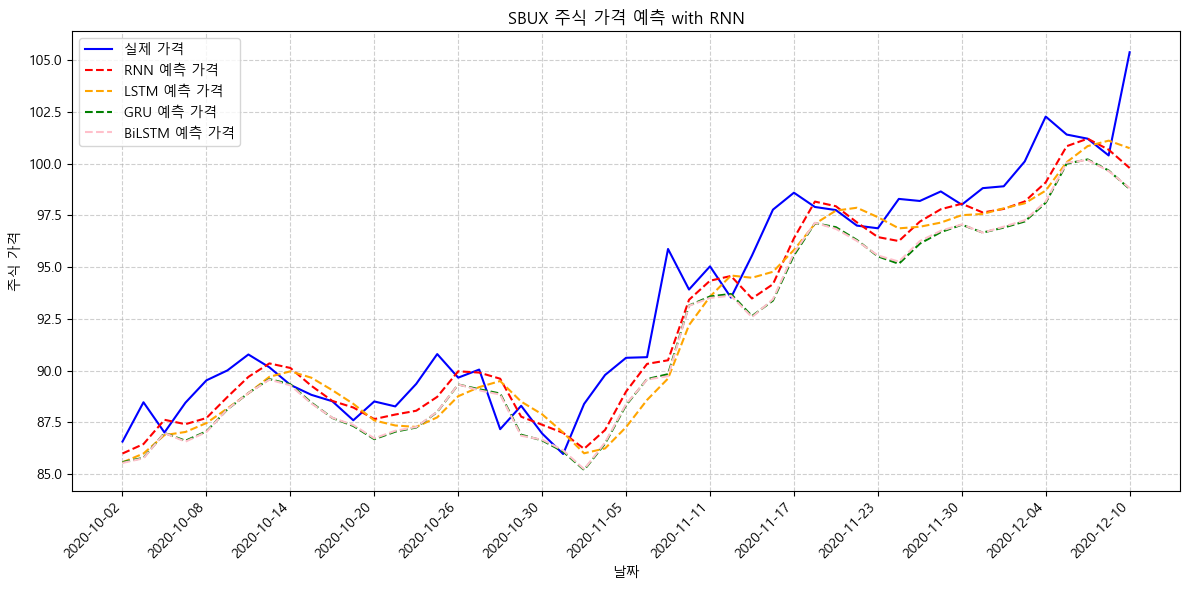

In [ ]:
# rnn
plt.plot(test_dataset.dates, y_test_rescaled, label='실제 가격', color='blue')
plt.plot(test_dataset.dates, rnn_test_predictions_rescaled, label='RNN 예측 가격', color='red', linestyle='--')
# plt.plot(test_dataset.dates, lstm_test_predictions_rescaled, label='LSTM 예측 가격', color='orange', linestyle='--')
# plt.plot(test_dataset.dates, gru_test_predictions_rescaled, label='GRU 예측 가격', color='green', linestyle='--')
plt.plot(test_dataset.dates, bilstm_test_predictions_rescaled, label='BiLSTM 예측 가격', color='pink', linestyle='--')
plt.xlabel('날짜')
plt.ylabel('주식 가격')
plt.title('SBUX 주식 가격 예측 with RNN')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:

rnn_mse = np.mean((y_test_rescaled - rnn_test_predictions_rescaled)**2)
# lstm_mse = np.mean((y_test_rescaled - lstm_test_predictions_rescaled)**2)
# gru_mse = np.mean((y_test_rescaled - gru_test_predictions_rescaled)**2)
bilstm_mse = np.mean((y_test_rescaled - bilstm_test_predictions_rescaled)**2)

print(f'RNN 모델 테스트 MSE (원래 스케일): {rnn_mse:.4f}')
print(f'LSTM 모델 테스트 MSE (원래 스케일): {lstm_mse:.4f}')
print(f'GRU 모델 테스트 MSE (원래 스케일): {gru_mse:.4f}')
print(f'BiLSTM 모델 테스트 MSE (원래 스케일): {bilstm_mse:.4f}')

RNN 모델 테스트 MSE (원래 스케일): 3.0509
LSTM 모델 테스트 MSE (원래 스케일): 3.9853
GRU 모델 테스트 MSE (원래 스케일): 5.2455
BiLSTM 모델 테스트 MSE (원래 스케일): 5.1816


- RSI
- 평균, rolling window